In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# 1. Download Data: MSCI World (URTH ETF) and S&P 500 (SPY ETF)
start_date = "2015-01-01"
end_date = "2023-12-31"
msci = yf.download("URTH", start=start_date, end=end_date)
sp500 = yf.download("SPY", start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# 2. Feature Engineering: Use technical indicators as features
"""
Feature Engineering Documentation:

The following features are computed for each row in the DataFrame:

- Return: Daily return, calculated as the percentage change of the 'Adj Close' price.
- MA5: 5-day moving average of the 'Adj Close' price, representing short-term trend.
- MA10: 10-day moving average of the 'Adj Close' price, representing medium-term trend.
- MA20: 20-day moving average of the 'Adj Close' price, representing longer-term trend.
- STD5: 5-day rolling standard deviation of the 'Adj Close' price, measuring short-term volatility.
- RSI: 14-day Relative Strength Index, a momentum oscillator that measures the speed and change of price movements. Calculated as:
    RSI = 100 - (100 / (1 + (mean of returns over 14 days) / (std of returns over 14 days)))
    Higher RSI values indicate overbought conditions, while lower values indicate oversold conditions.

All features are computed using rolling windows and require sufficient historical data, so initial rows with insufficient data are dropped.
"""
def add_features(df):
    df = df.copy()
    df['Return'] = df['Adj Close'].pct_change()
    df['MA5'] = df['Adj Close'].rolling(window=5).mean()
    df['MA10'] = df['Adj Close'].rolling(window=10).mean()
    df['MA20'] = df['Adj Close'].rolling(window=20).mean()
    df['STD5'] = df['Adj Close'].rolling(window=5).std()
    df['RSI'] = 100 - (100/(1 + df['Return'].rolling(window=14).mean() / df['Return'].rolling(window=14).std()))
    df = df.dropna()
    return df

# The downloaded msci dataframe uses MultiIndex columns (e.g., ('Close', 'URTH')).
# We need to flatten the columns and rename 'Close' to 'Adj Close' for compatibility.

msci_flat = msci.copy()
msci_flat.columns = [col[0] for col in msci_flat.columns]  # flatten columns
msci_flat = msci_flat.rename(columns={'Close': 'Adj Close'})
msci_feat = add_features(msci_flat)


In [4]:
# 3. Prepare Data for ML
features = ['MA5', 'MA10', 'MA20', 'STD5', 'RSI']
X = msci_feat[features].values
y = (msci_feat['Return'].shift(-1) > 0).astype(int).values[:-1]  # 1 if next day up, else 0
X = X[:-1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [5]:
# 4. Build Neural Network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# 6. Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

Epoch 1/30


/Users/simonadrianomunozlagunas/Desktop/Projects/Trading/trading_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5483 - loss: 0.6945 - val_accuracy: 0.5265 - val_loss: 0.6929
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5515 - loss: 0.6871 - val_accuracy: 0.5515 - val_loss: 0.6903
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5489 - loss: 0.6895 - val_accuracy: 0.5376 - val_loss: 0.6897
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5580 - loss: 0.6867 - val_accuracy: 0.5487 - val_loss: 0.6898
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5303 - loss: 0.6910 - val_accuracy: 0.5487 - val_loss: 0.6899
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5500 - loss: 0.6875 - val_accuracy: 0.5460 - val_loss: 0.6904
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5548 - loss: 0.6843 - val_accuracy: 0.5348 - val_loss: 0.6915
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5626 - loss: 0.6869 - val_accuracy: 0.5543 - val_loss: 0.6913
Epo

In [12]:
# 7. Backtest Strategy 
# Align msci_feat and X_scaled so their lengths match for prediction assignment
msci_feat = msci_feat.iloc[:-1]  # align with y and X_scaled[:-1]
# Predict only for the aligned msci_feat length
msci_feat['Pred'] = (model.predict(X_scaled[:len(msci_feat)]).flatten() > 0.5)
msci_feat['Strategy'] = msci_feat['Pred'].shift(1) * msci_feat['Return']
msci_feat['Strategy'].fillna(0, inplace=True)
msci_feat['Cumulative_Strategy'] = (1 + msci_feat['Strategy']).cumprod()
msci_feat['Cumulative_MSCI'] = (1 + msci_feat['Return']).cumprod()

# S&P 500 Benchmark
sp500 = sp500.loc[msci_feat.index]
sp500['Return'] = sp500[('Close', 'SPY')].pct_change().fillna(0)
sp500['Cumulative_SP500'] = (1 + sp500['Return']).cumprod()


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step


/var/folders/s4/0750y7y93tb7d2vxv6r614rm0000gn/T/ipykernel_67191/2410113347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msci_feat['Pred'] = (model.predict(X_scaled[:len(msci_feat)]).flatten() > 0.5)
/var/folders/s4/0750y7y93tb7d2vxv6r614rm0000gn/T/ipykernel_67191/2410113347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msci_feat['Strategy'] = msci_feat['Pred'].shift(1) * msci_feat['Return']
/var/folders/s4/0750y7y93tb7d2vxv6r614rm0000gn/T/ipykernel_67191/2410113347.py:7: FutureWarning: A value

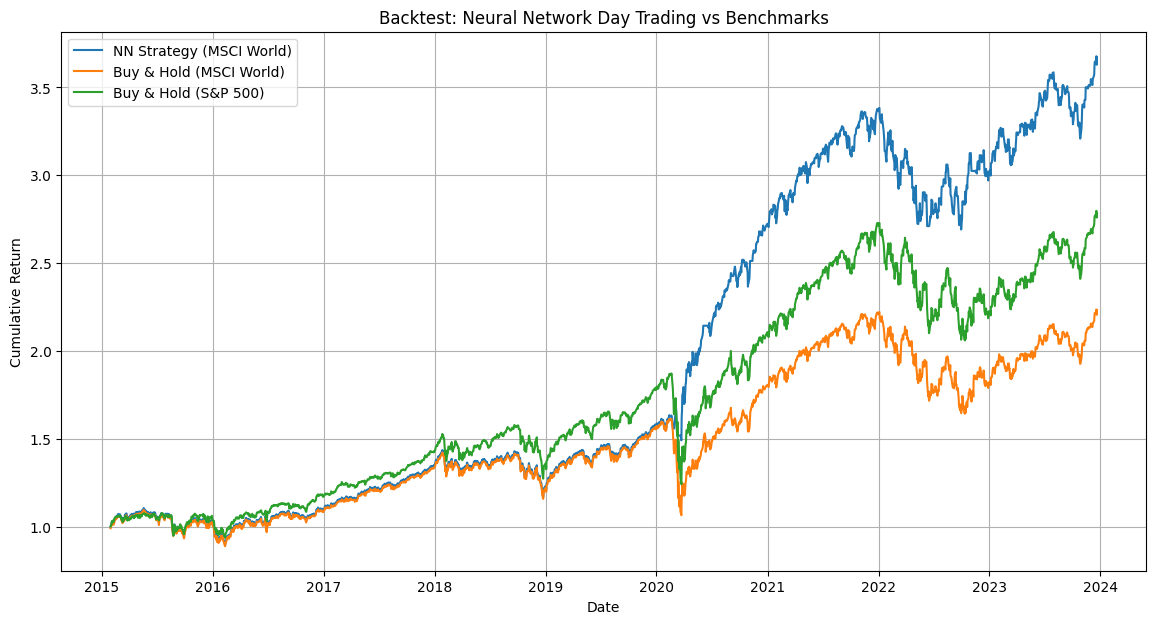

In [ ]:
# 8. Plot Results
plt.figure(figsize=(14,7))
plt.plot(msci_feat.index, msci_feat['Cumulative_Strategy'], label='NN Strategy (MSCI World)')
plt.plot(msci_feat.index, msci_feat['Cumulative_MSCI'], label='Buy & Hold (MSCI World)')
plt.plot(sp500.index, sp500['Cumulative_SP500'], label='Buy & Hold (S&P 500)')
plt.title('Backtest: Neural Network Day Trading vs Benchmarks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
#plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()

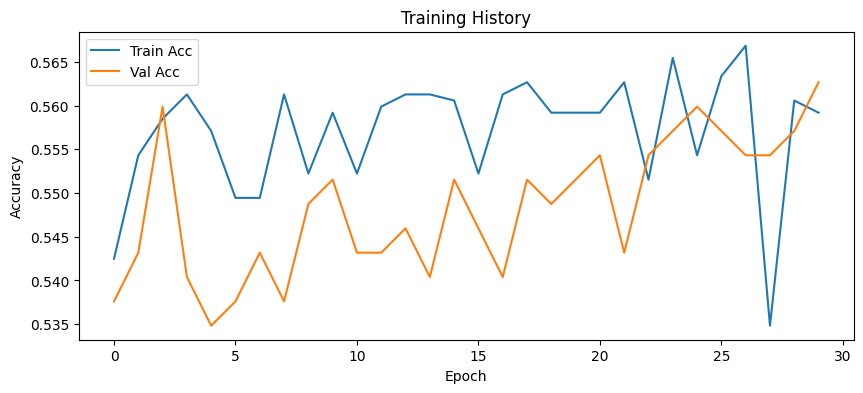

In [ ]:
# 9. Plot Training History
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


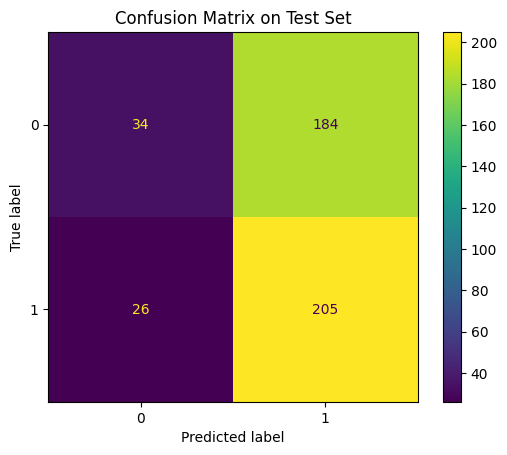

In [ ]:
# 10. Plot Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Test Set')
#plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# 11. Print Explanation
print("""
This script:
- Downloads daily data for MSCI World (URTH) and S&P 500 (SPY).
- Computes technical indicators as features.
- Trains a neural network to predict next-day up/down movement.
- Backtests a simple strategy: invest if model predicts up, else stay out.
- Benchmarks against buy-and-hold on MSCI World and S&P 500.
- Plots cumulative returns, training history, and confusion matrix.
""")


This script:
- Downloads daily data for MSCI World (URTH) and S&P 500 (SPY).
- Computes technical indicators as features.
- Trains a neural network to predict next-day up/down movement.
- Backtests a simple strategy: invest if model predicts up, else stay out.
- Benchmarks against buy-and-hold on MSCI World and S&P 500.
- Plots cumulative returns, training history, and confusion matrix.

